In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import cv2

In [2]:
assert hasattr(tf, "function")

In [3]:
dataset_dir = "quick_draw_dataset"
files = [name for name in os.listdir(dataset_dir) if ".npy" in name]
max_size_per_cl = 1500
draw_class = []

# Déterminer la taille de la dataset : 
size = 0
for name in files:
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 10 000 draw
    size += draws.shape[0]

images = np.zeros((size, 28, 28))
targets = np.zeros((size,))

it = 0
t = 0
for name in files:
    # On crée le tableau de classes : 
    draw_class.append(name.replace("full_numpy_bitmap_", "").replace(".npy", ""))
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 10 000 draw
    # Add images to the buffer
    images[it:it+draws.shape[0]] = np.invert(draws.reshape(-1, 28, 28))
    targets[it:it+draws.shape[0]] = t
    # Iter
    it += draws.shape[0]
    t += 1

images = images.astype(np.float32)
    
# Shuffle dataset
indexes = np.arange(size)
np.random.shuffle(indexes)
images = images[indexes]
targets = targets[indexes]

images, images_valid, targets, targets_valid = train_test_split(images, targets, test_size=0.33)

print("images.shape", images.shape)
print("targets.shape", targets.shape)

print("images_valid.shape", images_valid.shape)
print("targets_valid.shape", targets_valid.shape)

print(draw_class)

images.shape (10050, 28, 28)
targets.shape (10050,)
images_valid.shape (4950, 28, 28)
targets_valid.shape (4950,)
['book', 'dog', 'face', 'brain', 'The Eiffel Tower', 'eye', 'car', 'chair', 'apple', 'airplane']


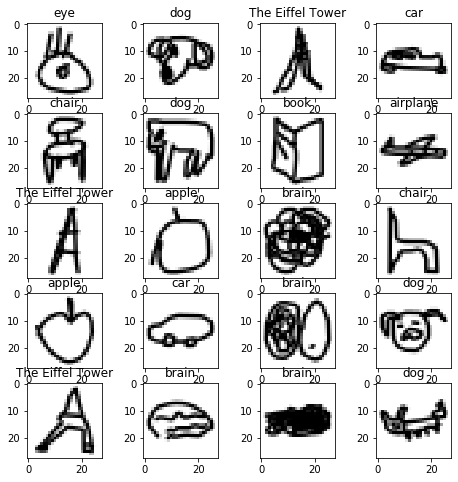

In [4]:
w = 10
h = 10
fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5
for i in range(1,columns*rows+1):
    index = np.random.randint(len(images))
    img = images[index]
    fig.add_subplot(rows,columns,i)
    plt.title(draw_class[int(targets[index])])
    plt.imshow(img , cmap="gray")
plt.show()

In [5]:
#Normalisation des données : 

print("Mean and std of images" , images.mean() , images.std())
scaler = StandardScaler()
scaled_images = scaler.fit_transform(images.reshape(-1,28*28))
scaled_images_valid = scaler.fit_transform(images_valid.reshape(-1,28*28))

scaled_images = scaled_images.reshape(-1,28,28,1)
scaled_images_valid = scaled_images_valid.reshape(-1,28,28,1)

print("Mean and std of images" , scaled_images.mean() , scaled_images.std())

Mean and std of images 209.54095 85.16808
Mean and std of images -5.499919e-10 0.92857134


In [6]:
#Création de la dataset : 

train_dataset = tf.data.Dataset.from_tensor_slices((scaled_images,targets))
valid_dataset = tf.data.Dataset.from_tensor_slices((scaled_images_valid,targets_valid))


In [7]:
epoch = 1
batch_size = 32
for images_batch,targets_batch in train_dataset.repeat(epoch).batch(batch_size):
    print(images_batch.shape,targets_batch.shape)
    break


(32, 28, 28, 1) (32,)


In [38]:
class ConvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        # Convolutions
        self.conv1 = tf.keras.layers.Conv2D(32, 4, activation='relu', name="conv1")
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size = (2,2), name = "pool1")
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', name="conv2")
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size = (2,2), name = "pool2") 
        self.conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', name="conv3")
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size = (2,2), name = "pool3")
        # Flatten the convolution
        self.flatten = tf.keras.layers.Flatten(name="flatten")       
        # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
        self.out = tf.keras.layers.Dense(10, activation='softmax', name="output")

    def call(self, image):
        conv1 = self.conv1(image)
        pool1 = self.pool1(conv1)
        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)
        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)
        flatten = self.flatten(pool3)
        d1 = self.d1(flatten)
        output = self.out(d1)
        return output

model = ConvModel()
model.predict(scaled_images[0:1])

array([[0.15422028, 0.09590096, 0.09495635, 0.09315912, 0.10523779,
        0.08880471, 0.07967667, 0.08742579, 0.11287016, 0.08774824]],
      dtype=float32)

In [39]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [40]:
# Loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [41]:
@tf.function
def train_step(image, targets):
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(image)
        # Get the error/loss on these predictions
        loss = loss_object(targets, predictions)
    # Compute the gradient which respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(targets, predictions)

In [42]:
@tf.function
def valid_step(image, targets):
    predictions = model(image)
    t_loss = loss_object(targets, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(targets, predictions)

In [44]:
epoch = 2
batch_size = 32
b = 0
for epoch in range(epoch):
    # Training set
    for images_batch, targets_batch in train_dataset.batch(batch_size):
        train_step(images_batch, targets_batch)
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(targets), train_loss.result(), 
            train_accuracy.result()*100
        ), end="")
        b += batch_size
    # Validation set
    for images_batch, targets_batch in valid_dataset.batch(batch_size):
        valid_step(images_batch, targets_batch)

    template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(
        epoch+1,
        valid_loss.result(), 
        valid_accuracy.result()*100)
    )
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()
    b = 0 

 Batch 10048/10050, Loss: 0.4060572385787964, Accuracy: 87.14427947998047
Epoch 1, Valid Loss: 0.5066576600074768, Valid Accuracy: 84.44444274902344
 Batch 10048/10050, Loss: 0.3094720244407654, Accuracy: 90.38806152343756
Epoch 2, Valid Loss: 0.5097383260726929, Valid Accuracy: 85.13130950927734


In [46]:
print(targets[0])
model.predict(scaled_images[0:1])

6.0


array([[3.4638809e-03, 4.0167924e-03, 1.9484266e-03, 5.0804433e-03,
        7.7520861e-05, 7.4626878e-06, 9.8491007e-01, 5.1728304e-05,
        1.3588996e-04, 3.0779419e-04]], dtype=float32)

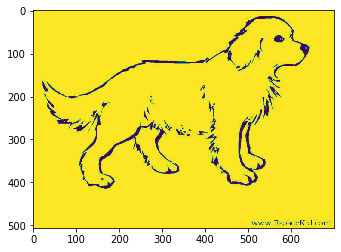

In [74]:
from skimage import color
from skimage import io 

img = color.rgb2gray(io.imread('Documents/X/PSC/Datasets/chien.jpg'))
plt.imshow(img)
plt.show()

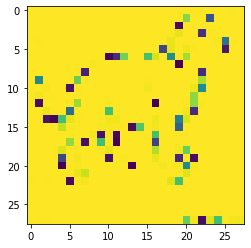

In [76]:
img = cv2.resize(img,(28,28))
plt.imshow(img)
plt.show()